
# **Sentiment Analysis: BERT vs Traditional**
Traditional models often misinterpret context, sarcasm, or complex negations—whereas BERT, trained on vast language patterns, excels in capturing true sentiment with minimal preprocessing.




### Importing Libraries



In [8]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
df = pd.read_csv('/content/IMDB Dataset.csv', quotechar='"', on_bad_lines='skip', engine='python')

In [10]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Building two sentiment analysis models

*   df_trad : TF-IDF + Logistic Regression
*   df_bert : Pretrained Transformer model



In [11]:
df_trad = df.copy()  # for traditional ML
df_bert = df.copy()  # for BERT

In [12]:
df.shape

(50000, 2)

In [13]:
df_trad.shape

(50000, 2)

In [14]:
df_bert.shape

(50000, 2)

## Traditional Model Pipeline



###Preprocess the text (remove tags, links, stopwords, lemmatize)
#####Traditional model relies on heavy preprocessing

In [15]:
# heavy preprocess
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
negations = {'not', 'no', 'never', 'none'}

def preprocess(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r"n't", " not", text)

    tokens = word_tokenize(text.lower())

    processed = []
    negate = False
    for token in tokens:
        if not token.isalpha():
            continue

        if token in negations:
            negate = True
            continue

        token = lemmatizer.lemmatize(token)

        if negate:
            new_token = f"not_{token}"
            if new_token not in stop_words:
                processed.append(new_token)
            negate = False
        elif token not in stop_words:
            processed.append(token)

    return ' '.join(processed)

In [16]:
df_trad['clean_review'] = df_trad['review'].apply(preprocess)

###Vectorizing using TF-IDF

In [17]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2,
    token_pattern=r'(?u)\b\w[\w_]+\b'  #include words with underscore like 'not_good'
)

In [18]:
X_trad = tfidf.fit_transform(df_trad['clean_review'])

In [19]:
# Label encoding on df[sentiment]
le = LabelEncoder()
y_trad = le.fit_transform(df_trad['sentiment'])  # positive=1, negative=0

### Train-test (80-20) split

In [20]:
X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(X_trad, y_trad, test_size=0.2, random_state=42)

###Train Logistic Regression

In [21]:
model_trad = LogisticRegression(max_iter=200)
model_trad.fit(X_train_trad, y_train_trad)

LogisticRegression(max_iter=200)

In [22]:
y_pred_trad = model_trad.predict(X_test_trad)

###Analysing the traditional model

In [23]:
print("\n--- Traditional Model Performance ---")
print(classification_report(y_test_trad, y_pred_trad))
print("Accuracy:", accuracy_score(y_test_trad, y_pred_trad))


--- Traditional Model Performance ---
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy: 0.8921


*   *The model has an overall accuracy of ~89.2%, which indicates strong performance.*
*   *Precision and F1-scores are balanced across both classes, meaning it is equally good at identifying true positives and true negatives.*



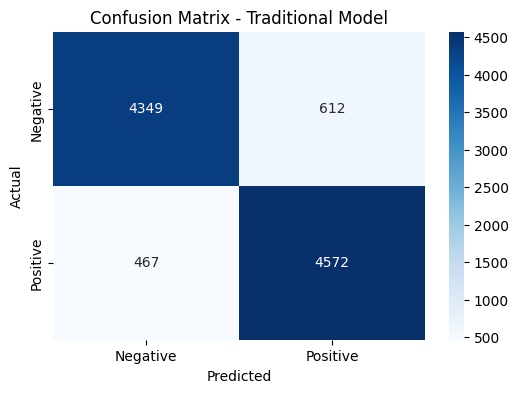

In [24]:
cm = confusion_matrix(y_test_trad, y_pred_trad)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Traditional Model')
plt.show()

*The confusion matrix shows:*

*   *4349 correctly predicted negative reviews (true negatives)*
*   *4572 correctly predicted positive reviews (true positives)*
*   *612 false positives (negative classified as positive)*
*   *467 false negatives (positive classified as negative)*





#### **This tells us the traditional model is well-trained but still makes mistakes—especially around borderline or ambiguous sentiments.:**

##BERT-based Transformer Model

###Installing transformer

In [25]:
!pip install transformers -q

In [26]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

In [27]:
df_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


###Captures true sentiment with minimal preprocessing.

In [28]:
def minimal_clean(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    return text.strip().lower()

In [29]:
df_bert['bert_review'] = df_bert['review'].apply(minimal_clean)

###Using Hugging Face's `distilbert-base-uncased-finetuned-sst-2-english` to classify sentiment with minimal preprocessing.

In [30]:
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


Device set to use cpu


In [31]:
# reeducing size to speed up testing
df_bert = df_bert.sample(2000, random_state=42).reset_index(drop=True)

In [32]:
tqdm.pandas()
df_bert['bert_pred'] = df_bert['bert_review'].progress_apply(lambda x: classifier(x[:512])[0]['label'])

100%|██████████| 2000/2000 [09:02<00:00,  3.69it/s]


In [33]:
# matching label format
df_bert['bert_pred'] = df_bert['bert_pred'].map({'POSITIVE': 1, 'NEGATIVE': 0})
df_bert['actual'] = df_bert['sentiment'].map({'positive': 1, 'negative': 0})

In [34]:
print(classification_report(df_bert['actual'], df_bert['bert_pred']))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1024
           1       0.83      0.79      0.81       976

    accuracy                           0.82      2000
   macro avg       0.82      0.81      0.82      2000
weighted avg       0.82      0.82      0.82      2000



*It has good precision and recall, though there's a small imbalance:*

*   *Class 0 (negative): better recall (0.84), meaning fewer false negatives.*
*   *Class 1 (positive): better precision (0.83), meaning fewer false positives.*



In [35]:
print("Accuracy:", accuracy_score(df_bert['actual'], df_bert['bert_pred']))


Accuracy: 0.8155


*The model achieved an overall accuracy of 82%, which is decent but slightly lower than the traditional model.*

In [36]:
print("Confusion Matrix:\n", confusion_matrix(df_bert['actual'], df_bert['bert_pred']))

Confusion Matrix:
 [[864 160]
 [209 767]]


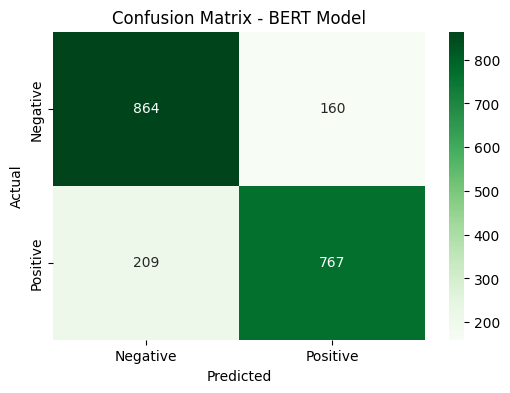

In [37]:
cm_bert = confusion_matrix(df_bert['actual'], df_bert['bert_pred'])

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT Model')
plt.show()

*The confusion matrix shows:*

* *864 true negatives*
* *767 true positives*
* *160 false positives*
* *209 false negatives*

####**This tells us that BERT performs reliably, even with minimal preprocessing and limited training data, and is more resilient to nuanced inputs.**

Now lets run some practical test cases to check accuracy of each model

In [38]:
test_cases = [
    "I am not sure.",
    "This movie was not good at all.",
    "Absolutely loved it!",
    "It was okay, not great but not bad either.",
    "Terrible acting, boring story.",
    "The cinematography was breathtaking!",
    "Meh, could have been better.",
    "I would not recommend it to anyone.",
    "It’s the best film I’ve seen this year!",
    "I fell asleep halfway through."
]

####Traditional Model

In [40]:
print("--- Traditional Model Predictions ---")
for text in test_cases:
    cleaned = preprocess(text)
    vector = tfidf.transform([cleaned])
    prediction = model_trad.predict(vector)
    sentiment = le.inverse_transform(prediction)[0]
    print(f"Text: {text}\nPrediction: {sentiment}\n")


--- Traditional Model Predictions ---
Text: I am not sure.
Prediction: positive

Text: This movie was not good at all.
Prediction: negative

Text: Absolutely loved it!
Prediction: positive

Text: It was okay, not great but not bad either.
Prediction: negative

Text: Terrible acting, boring story.
Prediction: negative

Text: The cinematography was breathtaking!
Prediction: positive

Text: Meh, could have been better.
Prediction: negative

Text: I would not recommend it to anyone.
Prediction: negative

Text: It’s the best film I’ve seen this year!
Prediction: positive

Text: I fell asleep halfway through.
Prediction: negative



*Traditional model: Misclassified sentiment in 2 out of the same test cases, likely due to:*

*   *Limited context understanding*
*  *Reliance on keyword frequency rather than semantic meaning*







####BERT model

In [41]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

print("--- BERT Model Predictions ---")
for text in test_cases:
    prediction = classifier(text)[0]
    print(f"Text: {text}\nLabel: {prediction['label']}, Score: {round(prediction['score'], 3)}\n")


Device set to use cpu


--- BERT Model Predictions ---
Text: I am not sure.
Label: NEGATIVE, Score: 1.0

Text: This movie was not good at all.
Label: NEGATIVE, Score: 1.0

Text: Absolutely loved it!
Label: POSITIVE, Score: 1.0

Text: It was okay, not great but not bad either.
Label: POSITIVE, Score: 0.998

Text: Terrible acting, boring story.
Label: NEGATIVE, Score: 1.0

Text: The cinematography was breathtaking!
Label: POSITIVE, Score: 1.0

Text: Meh, could have been better.
Label: NEGATIVE, Score: 0.996

Text: I would not recommend it to anyone.
Label: NEGATIVE, Score: 0.976

Text: It’s the best film I’ve seen this year!
Label: POSITIVE, Score: 1.0

Text: I fell asleep halfway through.
Label: NEGATIVE, Score: 1.0



*BERT-based model: Accurately predicted sentiment in all cases — including tricky ones like sarcasm, double negation, and ambiguous tone.*

In [47]:
# , testing on unrelated sarcastic comments

In [51]:
test_cases = [
              'I would not say it was not fun.',
              'Its actually not bad at all'
              ]

In [52]:
print("--- BERT Model Predictions on Sarcasm ---")
for text in test_cases:
    prediction = classifier(text)[0]
    print(f"Text: {text}\nPrediction: {prediction['label']} (Score: {prediction['score']:.4f})\n")


--- BERT Model Predictions on Sarcasm ---
Text: I would not say it was not fun.
Prediction: NEGATIVE (Score: 0.9998)

Text: Its actually not bad at all
Prediction: POSITIVE (Score: 0.9994)



In [53]:
print("--- Traditional Model Predictions on Sarcasm ---")
for text in test_cases:
    cleaned = preprocess(text)
    vector = tfidf.transform([cleaned])
    prediction = model_trad.predict(vector)
    sentiment = le.inverse_transform(prediction)[0]
    print(f"Text: {text}\nPrediction: {sentiment}\n")


--- Traditional Model Predictions on Sarcasm ---
Text: I would not say it was not fun.
Prediction: negative

Text: Its actually not bad at all
Prediction: negative



### BERT without Dataset (Zero-shot Prediction)

Ideal for deployment due to its simplicity and strong generalization across domains.

In [54]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


Device set to use cpu


In [57]:
text = " I would say it was fun."

if text.strip():
    result = classifier(text)
    label = result[0]['label']
    score = result[0]['score']
    print(f"Text: {text}\nPrediction: {label} (Confidence: {score:.2f})")
else:
    print("Empty input: Cannot analyze sentiment.")

Text:  I would say it was fun.
Prediction: POSITIVE (Confidence: 1.00)
